In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# For Sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


In [2]:
cd ..

/Users/logang/Dropbox/GrosenickLab/Code/PCMF


In [3]:
def generate_PMD_data(m=100, n_X=10, sigma=1, density=0.5, mean=0, seed=1):
    "Generates data matrix for PCMF."
    np.random.seed(seed)
    u_star = np.random.randn(m) / 3.0
    v_star = np.random.randn(n_X) / 3.0
    X = np.random.normal(mean,sigma,size=((m,n_X))) / 3.0
    X_idxs = np.random.choice(range(n_X), int(density*n_X), replace=False)
    for idx in X_idxs:
        X[:,idx] += v_star[idx]*u_star

    return X, u_star, v_star

def generate_cluster_PMD_data(m=[50,50,20], n_X=20, sigma=0.075, density=1.0, n_clusters=3, 
                              means=[-0.35,0.2,0.35], gen_seeds=True, seeds=[], verbose=False):
    '''
    Generates multiple cluster data matrix for PCMF.
    '''
    X_out = []
    u_stars = []
    v_stars = []

    for nc in range(n_clusters):
        if gen_seeds is True:
            seed = np.random.randint(99999)
            seeds.append(seed)
            # print('generating seeds')                                                                                  
        # else:                                                                                                          
            # print(seeds)                                                                                               
            # print('NOT generating seeds')                                                                              

        if verbose == True:
            print(seeds)

        X, u_star, v_star = generate_PMD_data(m[nc], n_X, sigma, density, mean=means[nc], seed=seeds[nc])
        X_out.append(X)
        u_stars.append(u_star)
        v_stars.append(v_star)
    return X_out, u_stars, v_stars, seeds



Generate data

In [4]:
# Set data generation parameters
m = [100,20,20]
n_X = 20
sigma = 0.075
density = 1.0
n_clusters = 3
means = [-0.35, 0.0, 0.35]
true_clusters = np.repeat([0,1,2],m)

# Generate clusters
X_clusters, u_true, v_true, _ = generate_cluster_PMD_data(m, n_X, sigma, density, n_clusters=n_clusters, means=means, seeds=[42]) #8# row 1,3

# Add random intercept to one cluster and stack into data matrix
X_clusters[0] += 0.4
#X_clusters[0] += 0.3*np.random.randn(n_X)
X_c = np.vstack(X_clusters)


Set model parameters

In [5]:
num_clusters = 3
num_components = 4
colors = ['darkblue','darkorange','red','green','purple']
plot_idxs = [0,1]
scatter_cmap = 'tab20b'
scatter_alpha = 0.5

Plot generated data

(140, 140)

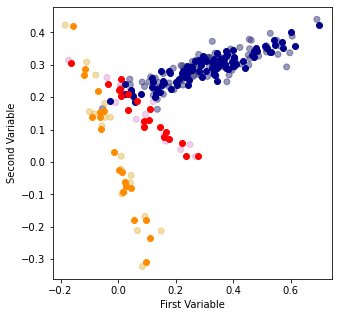

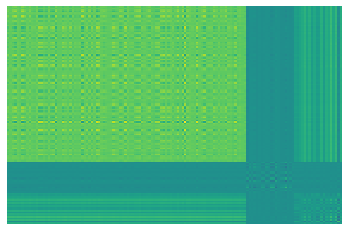

In [6]:
# Plot clusters
plt.figure(figsize=(5,5))
plt.scatter(X_c[:,plot_idxs[0]],X_c[:,plot_idxs[1]], c=true_clusters, cmap=scatter_cmap, alpha=scatter_alpha)
plt.xlabel('First Variable')
plt.ylabel('Second Variable')

# Plot PCA approximation with num_components components
X_pcas = list()
for ncl in range(num_clusters):
    idx = np.where(true_clusters==ncl)[0]
    u,d,vh = np.linalg.svd(X_c[idx,:], full_matrices=False)
    X_pca = np.dot(np.dot(u[:,0:num_components],np.diag(d[0:num_components])),vh[0:num_components,:])
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[ncl])

# Plot Covariance
plt.figure()
C = np.dot(X_c,X_c.T)
maxval = np.max(np.abs(C))
plt.imshow(C,aspect='auto',interpolation='nearest',cmap='viridis',vmin=-1*maxval, vmax=maxval)  
plt.axis('off')

C.shape




Clustering then PCA

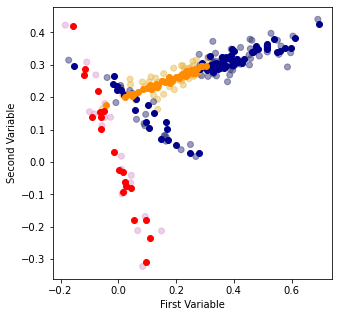

(20, 20)

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

# Cluster
spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit(X_c)
spectral_labels = spectral_clustering.labels_
#kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X_c)
#kmeans_labels = kmeans.labels_

# Plot PCA
plt.figure(figsize=(5,5))
plt.scatter(X_c[:, plot_idxs[0]], X_c[:, plot_idxs[1]], c=spectral_labels, cmap=scatter_cmap, alpha=scatter_alpha)
plt.xlabel('First Variable')
plt.ylabel('Second Variable')

X_pcas = list()
for ncl in range(num_clusters):
    idx = np.where(spectral_labels==ncl)[0]
    u,d,vh = np.linalg.svd(X_c[idx,:], full_matrices=False)
    X_pca = np.dot(np.dot(u[:,0:num_components],np.diag(d[0:num_components])),vh[0:num_components,:])
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[ncl])

plt.show()


PCA then Clustering

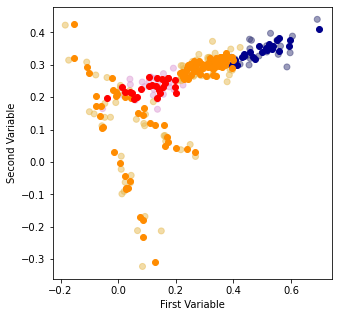

In [8]:
# Fit PCA + spectral clustering
u,d,vh = np.linalg.svd(X_c, full_matrices=False)
pca_spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit(u[:,0:num_components])
pca_labels = pca_spectral_clustering.labels_

# Plot results
plt.figure(figsize=(5,5))
plt.scatter(X_c[:,0], X_c[:,1], c=pca_labels, cmap=scatter_cmap, alpha=scatter_alpha) 
plt.xlabel('First Variable')
plt.ylabel('Second Variable')

X_pcas = list()
for ncl in range(num_clusters):
    idx = np.where(pca_labels==ncl)[0]
    u,d,vh = np.linalg.svd(X_c[idx,:], full_matrices=False)
    X_pca = np.dot(np.dot(u[:,0:num_components],np.diag(d[0:num_components])),vh[0:num_components,:])
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[ncl])

#plt.axis('off')


Set the penalty list for experiments

In [9]:
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-20,5,150))[::-1]),axis=0)


### Run PCMF on synthetic data

In [10]:
from matplotlib import cm

def path_plot(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10)):
    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = cm.get_cmap('viridis', coefficient_arr.shape[2])
    colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[2]))

    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)
    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['solid']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'dashed'
                    color_list[j] = 'red'
                elif tc == 2:
                    linetypes[j] = 'dotted'
                    color_list[j] = 'green'
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = 'blue'
                else:
                    linetypes[j] = 'solid'
                    color_list[j] = 'grey'

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.15)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.15)
        # Set plot ticks and labels
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_xticklabels(x,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.tick_params(axis='y', labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=24)
    plt.ylabel('Coefficients',fontsize=24)
    

Divisive pathwise clustering

In [11]:
from pcmf import pcmf_full, pcmf_approx_uV, plot_ordercolor, plot_cluster_assignments

gc = 2.0 

# Fit full model
A_list, U_list, s_list, V_list = pcmf_full(X_c, penalty_list, problem_rank=num_components, rho=1.0, gauss_coef=gc, weights='Gaussian', admm_iters = 10, neighbors=25)

# Fit partial u,V model
#V_list_approx_uV, u_list_approx_uV, s_list_approx_uV =  pcmf_approx_uV(X_c, penalty_list, rho=1.5, gauss_coef=gc, weights='Gaussian', admm_iters = 5, neighbors=15)


weights: Gaussian neighbors: 25 gauss_coef: 2.0 rho: 1.0
[ 1 ] inf...

/Users/logang/Dropbox/GrosenickLab/Code/PCMF/pcmf.py:555: RuntimeWarning: invalid value encountered in double_scalars
  G = cprox(D*A+Z1, penalty, rho, weights)


[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.25489e+02...[ 13 ] 1.06105e+02...[ 14 ] 8.97156e+01...[ 15 ] 7.58577e+01...[ 16 ] 6.41404e+01...[ 17 ] 5.42329e+01...[ 18 ] 4.58559e+01...[ 19 ] 3.87728e+01...[ 20 ] 3.27837e+01...[ 21 ] 2.77198e+01...[ 22 ] 2.34381e+01...[ 23 ] 1.98177e+01...[ 24 ] 1.67566e+01...[ 25 ] 1.41683e+01...[ 26 ] 1.19798e+01...[ 27 ] 1.01293e+01...[ 28 ] 8.56472e+00...[ 29 ] 7.24177e+00...[ 30 ] 6.12317e+00...[ 31 ] 5.17736e+00...[ 32 ] 4.37764e+00...[ 33 ] 3.70145e+00...[ 34 ] 3.12971e+00...[ 35 ] 2.64628e+00...[ 36 ] 2.23752e+00...[ 37 ] 1.89190e+00...[ 38 ] 1.59967e+00...[ 39 ] 1.35258e+00...[ 40 ] 1.14365e+00...[ 41 ] 9.67000e-01...[ 42 ] 8.17633e-01...[ 43 ] 6.91337e-01...[ 44 ] 5.84550e-01...[ 45 ] 4.94258e-01...[ 46 ] 4.17912e-01...[ 47 ] 3.53360e-01...[ 48 ] 2.98778e-01...[ 49 ] 2.52628e-01...[ 50 ] 2.13606e-01...[ 51 ] 1.80611e-01...[ 52 ] 1.52713e-01...[ 53 ] 1.

In [68]:
from scipy.sparse import csr_matrix
from itertools import combinations
import networkx as nx
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

def sparse_D(n,p):
    '''                                                                                                                  
    Construct a sparse matrix, that when applied to a vector containing concatenated vectors                             
    of coefficients b = [b_1 b_2 ... b_n] where each b_i is p=num_var long and there are                                 
    n = num_vec of them. Differences are taken between conformal elements (e.g. b_11 and b_21)                           
    across all unique pairwise combinations of vectors.                                                                  
    '''
    comb_list = list(combinations(range(n),2))
    combs_arr = np.array(comb_list)
    num_combs = combs_arr.shape[0]
    data = np.ones_like(combs_arr)
    data[:,1] *= -1
    row = np.repeat(range(num_combs),2)
    col = combs_arr.flatten()
    return csr_matrix((data.flatten(), (row, col)), shape=(num_combs, n)), comb_list

def diff_graph_cluster(Xhat, D, comb_list, num_clusters, thresh_sd=6, pca_clean=True, num_fits=1, plot_thresh_hist=False):
    '''
    Given a PCMF data approximation 'Xhat' for a fixed lambda and a differencing matrix 'D', calculate the 
    difference variable graph as suggested in Chi and Lange JCGC (2015), clustering on the graph adjacency 
    matrix (or a PCA embedding of it if pca_clean=True).
    
    Args:
        Xhat - PCMF data approximation at a fixed penalty parameter.
        D - a sparse differencing matrix given by 'sparse_D'.
        comb_list - the combination indices returned by 'sparse_D'.
        num_clusters - the number of clusters.
        thresh_sd - a threshold standard deviation cuttoff for thresholding the difference graph.
        pca_clean - boolean; should the PCA of the adjacency matrix be used for clustering. 
        num_fits - number of spectral clusterings to take the median of for output. 
        plot_thresh_hist - plot histogram of difference graph edges and show GMM fit used to choose threshold.

    '''
    # Get graph edges from distances, and estimate graph threshold from edge mode centered around zero
    edges = np.sum(D*Xhat,axis=1)
    #edges = np.median(D*Xhat,axis=1)

    gmm = GaussianMixture(n_components = 6, max_iter=200, n_init=10).fit(edges.reshape(-1, 1))
    zero_mode_idx = np.where(np.abs(gmm.means_)==np.min(np.abs(gmm.means_)))[0]
    thresh = thresh_sd*np.sqrt(gmm.covariances_[zero_mode_idx])
    
    # Make adjacency from sum of differences (and adjust threshold if necessary) 
    flag = True
    while flag==True:
        # Generate graph
        G = nx.Graph()
        for i,e in enumerate(edges):
            if np.abs(e) < thresh:
                G.add_edge(comb_list[i][0], comb_list[i][1])
        A = nx.adjacency_matrix(G).toarray()
        print('threshold:',thresh)
        if A.shape[0] < Xhat.shape[0]:
            thresh *= 1.1
        else:
            flag = False
            
    # Apply spectral clustering, taking median of 'num_fits' tryes to get output labels
    out_labels = []
    for f in range(num_fits):
        # Use PCA of A if 'pca_clean' flag set
        if pca_clean:
            uA, sA, vhA = np.linalg.svd(A)
            spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit(uA[:,0:num_clusters])
            out_labels.append(spectral_clustering.labels_)
        else:
            spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit(A)
            out_labels.append(spectral_clustering.labels_)
            
    # Plot thresholding histogram if 'plot_thresh_hist' is true
    if plot_thresh_hist:
        plt.figure(figsize=(10,5))
        _ = plt.hist(edges,bins=100,density=True)

        f_axis = edges.copy().ravel()
        f_axis.sort()
        a = []
        for weight, mean, covar in zip(gmm.weights_, gmm.means_, gmm.covariances_):
            a.append(weight*norm.pdf(f_axis, mean, np.sqrt(covar)).ravel())
            plt.plot(f_axis, a[-1])
        plt.plot(f_axis, np.array(a).sum(axis=0), 'k-')
        plt.xlabel('Variable')
        plt.ylabel('PDF')
        plt.tight_layout()
        plt.show()
        
    return np.median(np.array(out_labels),axis=0)

D, comb_list = sparse_D(X_c.shape[0],X_c.shape[1])



threshold: [[[0.88775224]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


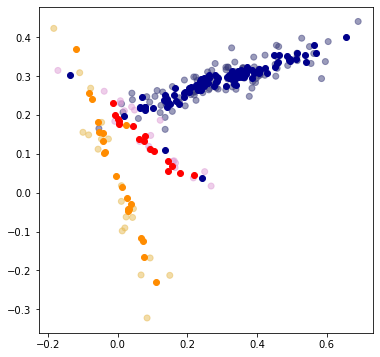

In [69]:
# Plot results for one value of lambda with data and PCMF estimate overlay
plt.figure(figsize=(6,6))
plt.scatter(X_c[:,0], X_c[:,1], c=true_clusters, cmap=scatter_cmap, alpha=scatter_alpha) 

lambda_idx = 90
U = U_list[lambda_idx]
s = s_list[lambda_idx]
V = V_list[lambda_idx]

cluster_pcmf = diff_graph_cluster(np.array(A_list[90]), D, comb_list, num_clusters).astype(int)

#X_pcmf = np.dot(np.dot(U[:,0:num_components],np.diag(s[0:num_components])),V[0:num_components,:])
#pcmf_spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit()
#pcmf_labels = pcmf_spectral_clustering.labels_

#plt.figure(figsize=(6,6))
X_pcas = list()
for ncl in range(num_clusters):
    idx = np.where(cluster_pcmf==ncl)[0]
    X_pcmf = np.dot(np.dot(U[:,0:num_components],np.diag(s[0:num_components])),V[0:num_components,:])
    plt.scatter(X_pcmf[idx, 0], X_pcmf[idx, 1], c=colors[ncl])
    
    

threshold: [[[0.00612213]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.19907528]]]
threshold: [[[0.21898281]]]
threshold: [[[0.24088109]]]
threshold: [[[0.2649692]]]
threshold: [[[0.29146612]]]
threshold: [[[0.32061273]]]
threshold: [[[0.352674]]]
threshold: [[[0.88767839]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.13937547]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


[Text(0, 0.5, 'Second Variable')]

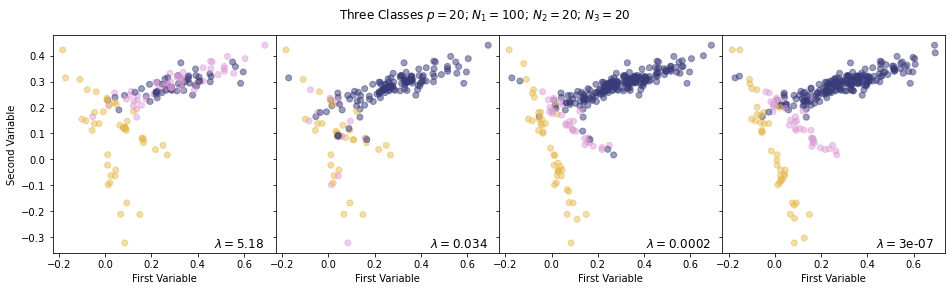

In [70]:
# Plot four clusterings with data and PCMF overlay
idxs = [30,60,90,130]
rounds = [2,3,4,7]
fig = plt.figure(figsize=(16,4))
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle(r'Three Classes $p=%i$;'%n_X + ' $N_1=%i$;'%m[0]+' $N_2=%i$;'%m[1]+' $N_3=%i$'%m[2])

for a,ax in enumerate(axs):
    idx = idxs[a]
    cluster_pcmf = diff_graph_cluster(np.array(A_list[idx]), D, comb_list, num_clusters).astype(int)
    ax.scatter(X_c[:,0], X_c[:,1], c=cluster_pcmf, alpha=scatter_alpha, cmap=scatter_cmap)
    #plt.axis("off")
    
    #plt.figure(figsize=(6,6))
    #Xhat_approxUV_list = []
    #for i in range(len(penalty_list)):
    #    Xhat_approxUV_list.append(u_list_approx_uV[i] * V_list_approx_uV[i]*s_list[i][0])  
    #ax.scatter(np.asarray(Xhat_approxUV_list)[idx,:,0],np.asarray(Xhat_approxUV_list)[idx,:,1], c=true_clusters, cmap='bwr')
    #plt.axis("off")

    ax.scatter(np.asarray(A_list)[idx,:,0],np.asarray(A_list)[idx,:,1], c=cluster_pcmf, cmap=scatter_cmap, alpha=scatter_alpha)
    ax.set(xlabel="First Variable")
    ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[idx],rounds[a])),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)
    
    #plt.axis("off")
axs[0].set(ylabel="Second Variable")




threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.006]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.04142376]]]
threshold: [[[0.02042772]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.04111546]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01044143]]]
threshold: [[[0.01148558]]]
threshold: [[[0.01263413]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.02661925]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.03711459]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.0354069]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01378374]]]
threshold: [[[0.01620414]]]
threshold: [[[0.01782455]]]
threshold: [[[0.01960701]]]
threshold: [[[0.02156771]]]
threshold: [[[0.02372448]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01321686]]]
threshold: [[[0.01383964]]]
threshold: [[[0.01522361]]]
threshold: [[[0.01674597]]]
threshold: [[[0.01842057]]]
threshold: [[[0.02026262]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01364333]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00944147]]]
threshold: [[[0.01038561]]]
threshold: [[[0.01142417]]]
threshold: [[[0.01256659]]]
threshold: [[[0.01382325]]]
threshold: [[[0.01520557]]]
threshold: [[[0.01672613]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.0126124]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01234529]]]
threshold: [[[0.01357982]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01439457]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00670655]]]
threshold: [[[0.0073772]]]
threshold: [[[0.00811493]]]
threshold: [[[0.00892642]]]
threshold: [[[0.00981906]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01539845]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01602458]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01316035]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00612215]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.0109456]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01488526]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.0121483]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00666085]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00842993]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01172276]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01073915]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00697134]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00685903]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00950916]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.0095041]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00710317]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00618373]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.0080525]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00856179]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00795802]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00978335]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00792365]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00626138]]]
threshold: [[[0.00688752]]]
threshold: [[[0.00757627]]]
threshold: [[[0.0083339]]]
threshold: [[[0.00916729]]]
threshold: [[[0.01008402]]]
threshold: [[[0.01109242]]]
threshold: [[[0.01220166]]]
threshold: [[[0.01342183]]]
threshold: [[[0.01476401]]]
threshold: [[[0.01624041]]]
threshold: [[[0.01786445]]]
threshold: [[[0.0196509]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00635229]]]
threshold: [[[0.00698751]]]
threshold: [[[0.00768627]]]
threshold: [[[0.00845489]]]
threshold: [[[0.00930038]]]
threshold: [[[0.01023042]]]
threshold: [[[0.01125346]]]
threshold: [[[0.01237881]]]
threshold: [[[0.01361669]]]
threshold: [[[0.01497836]]]
threshold: [[[0.01647619]]]
threshold: [[[0.01812381]]]
threshold: [[[0.0199362]]]
threshold: [[[0.02192982]]]
threshold: [[[0.0241228]]]
threshold: [[[0.02653508]]]
threshold: [[[0.02918858]]]
threshold: [[[0.03210744]]]
threshold: [[[0.03531819]]]
threshold: [[[0.03885001]]]
threshold: [[[0.04273501]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00630268]]]
threshold: [[[0.00693295]]]
threshold: [[[0.00762624]]]
threshold: [[[0.00838887]]]
threshold: [[[0.00922775]]]
threshold: [[[0.01015053]]]
threshold: [[[0.01116558]]]
threshold: [[[0.01228214]]]
threshold: [[[0.01351036]]]
threshold: [[[0.01486139]]]
threshold: [[[0.01634753]]]
threshold: [[[0.01798228]]]
threshold: [[[0.01978051]]]
threshold: [[[0.02175856]]]
threshold: [[[0.02393442]]]
threshold: [[[0.02632786]]]
threshold: [[[0.02896065]]]
threshold: [[[0.03185671]]]
threshold: [[[0.03504238]]]
threshold: [[[0.03854662]]]
threshold: [[[0.04240128]]]
threshold: [[[0.04664141]]]
threshold: [[[0.05130555]]]
threshold: [[[0.05643611]]]
threshold: [[[0.06207972]]]
threshold: [[[0.06828769]]]
threshold: [[[0.07511646]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.08180223]]]
threshold: [[[0.08998245]]]
threshold: [[[0.09898069]]]
threshold: [[[0.10887876]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.10412084]]]
threshold: [[[0.11453292]]]
threshold: [[[0.12598621]]]
threshold: [[[0.13858484]]]
threshold: [[[0.15244332]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00616469]]]
threshold: [[[0.00678116]]]
threshold: [[[0.00745928]]]
threshold: [[[0.00820521]]]
threshold: [[[0.00902573]]]
threshold: [[[0.0099283]]]
threshold: [[[0.01092113]]]
threshold: [[[0.01201324]]]
threshold: [[[0.01321457]]]
threshold: [[[0.01453602]]]
threshold: [[[0.01598962]]]
threshold: [[[0.01758859]]]
threshold: [[[0.01934745]]]
threshold: [[[0.02128219]]]
threshold: [[[0.02341041]]]
threshold: [[[0.02575145]]]
threshold: [[[0.0283266]]]
threshold: [[[0.03115925]]]
threshold: [[[0.03427518]]]
threshold: [[[0.0377027]]]
threshold: [[[0.04147297]]]
threshold: [[[0.04562026]]]
threshold: [[[0.05018229]]]
threshold: [[[0.05520052]]]
threshold: [[[0.06072057]]]
threshold: [[[0.06679263]]]
threshold: [[[0.07347189]]]
threshold: [[[0.08081908]]]
threshold: [[[0.08890099]]]
threshold: [[[0.09779109]]]
threshold: [[[0.1075702]]]
threshold: [[[0.11832722]]]
threshold: [[[0.13015994]]]
threshold: [[[0.14317593]]]
threshold: [[[0.15749353]]]
threshold: [[[0.17324288

/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.00667369]]]
threshold: [[[0.00734106]]]
threshold: [[[0.00807517]]]
threshold: [[[0.00888268]]]
threshold: [[[0.00977095]]]
threshold: [[[0.01074805]]]
threshold: [[[0.01182285]]]
threshold: [[[0.01300514]]]
threshold: [[[0.01430565]]]
threshold: [[[0.01573622]]]
threshold: [[[0.01730984]]]
threshold: [[[0.01904082]]]
threshold: [[[0.02094491]]]
threshold: [[[0.0230394]]]
threshold: [[[0.02534334]]]
threshold: [[[0.02787767]]]
threshold: [[[0.03066544]]]
threshold: [[[0.03373198]]]
threshold: [[[0.03710518]]]
threshold: [[[0.0408157]]]
threshold: [[[0.04489727]]]
threshold: [[[0.04938699]]]
threshold: [[[0.05432569]]]
threshold: [[[0.05975826]]]
threshold: [[[0.06573409]]]
threshold: [[[0.0723075]]]
threshold: [[[0.07953825]]]
threshold: [[[0.08749207]]]
threshold: [[[0.09624128]]]
threshold: [[[0.10586541]]]
threshold: [[[0.11645195]]]
threshold: [[[0.12809714]]]
threshold: [[[0.14090686]]]
threshold: [[[0.15499754]]]
threshold: [[[0.1704973]]]
threshold: [[[0.18754703

/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.24301775]]]
threshold: [[[0.26731953]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.20220613]]]
threshold: [[[0.22242675]]]
threshold: [[[0.24466942]]]
threshold: [[[0.26913636]]]
threshold: [[[0.29605]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.01615201]]]
threshold: [[[0.01776721]]]
threshold: [[[0.01954393]]]
threshold: [[[0.02149832]]]
threshold: [[[0.02364815]]]
threshold: [[[0.02601297]]]
threshold: [[[0.02861426]]]
threshold: [[[0.03147569]]]
threshold: [[[0.03462326]]]
threshold: [[[0.03808559]]]
threshold: [[[0.04189414]]]
threshold: [[[0.04608356]]]
threshold: [[[0.05069191]]]
threshold: [[[0.05576111]]]
threshold: [[[0.06133722]]]
threshold: [[[0.06747094]]]
threshold: [[[0.07421803]]]
threshold: [[[0.08163983]]]
threshold: [[[0.08980382]]]
threshold: [[[0.0987842]]]
threshold: [[[0.10866262]]]
threshold: [[[0.11952888]]]
threshold: [[[0.13148177]]]
threshold: [[[0.14462995]]]
threshold: [[[0.15909294]]]
threshold: [[[0.17500224]]]
threshold: [[[0.19250246]]]
threshold: [[[0.2117527]]]
threshold: [[[0.23292798]]]
threshold: [[[0.25622077]]]
threshold: [[[0.28184285]]]
threshold: [[[0.31002714]]]
threshold: [[[0.34102985]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.2523714]]]
threshold: [[[0.27760854]]]
threshold: [[[0.3053694]]]
threshold: [[[0.33590634]]]
threshold: [[[0.27179073]]]
threshold: [[[0.29896981]]]
threshold: [[[0.32886679]]]
threshold: [[[0.36175347]]]
threshold: [[[0.2976532]]]
threshold: [[[0.32741852]]]
threshold: [[[0.36016038]]]
threshold: [[[0.32844095]]]
threshold: [[[0.36128505]]]
threshold: [[[0.36143724]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.39315084]]]
threshold: [[[0.42870173]]]
threshold: [[[0.4204173]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.45331995]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.45743112]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.47673521]]]
threshold: [[[0.49676113]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.51237713]]]
threshold: [[[0.533541]]]
threshold: [[[0.55371261]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.57426948]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.5942784]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.61530588]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.63618229]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.65728383]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.67822369]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.69862001]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.72039334]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.73993976]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.76156582]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.78139723]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.80089053]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.81956585]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.83790964]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.85557991]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.87249591]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.88778747]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.90362222]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.91866835]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.93305654]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.94821277]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.96119304]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.97350449]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.98514415]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[0.99619884]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.00649272]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.01609849]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.02523188]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.03375828]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.04181457]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.05070443]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.05769878]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.06417148]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.07039206]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.07605639]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.081502]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.08645842]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.09122911]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.09555693]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.09964391]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.10352081]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.10713222]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.11039954]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.11352317]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.11642326]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.119216]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.12166898]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.12412415]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.12627777]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.12839594]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.13026529]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.13207625]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.13379145]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.1352948]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.13681797]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.13811319]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.13941782]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14056979]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14165716]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14270162]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14364046]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14453714]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14535042]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14615492]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14687493]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14754838]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14814931]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14881802]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14927972]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.14978957]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15026158]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15070256]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15111442]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.1515303]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15194259]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15222048]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15253705]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15281146]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15306808]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15333329]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15356271]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15381014]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15398695]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15417312]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15435242]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


threshold: [[[1.15449689]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


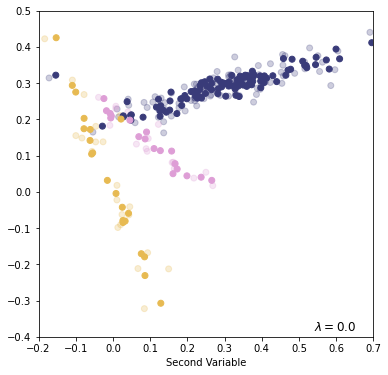

In [71]:
# Generate video of solutions along path
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

#Xhat_approxUV_list = []
#for i in range(len(penalty_list)):
#    Xhat_approxUV_list.append(u_list_approx_uV[i] * V_list_approx_uV[i]*s_list[i][0])  
#plt.axis("off")

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

fig = plt.figure(figsize=(6,6))
l = plt.scatter([], [])

plt.xlim(-0.2, 0.7)
plt.ylim(-0.4, 0.5)

#x0 = Xu_preds[0] 
#y0 = Yv_preds[0]

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

with writer.saving(fig, "writer_test.mp4", 300):
    for i in range(len(penalty_list)):
        fig.clear()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))
        cluster_pcmf = diff_graph_cluster(np.array(A_list[i]), D, comb_list, num_clusters).astype(int)

        ax.scatter(X_c[:,0],X_c[:,1],c=cluster_pcmf, alpha=0.25, cmap=scatter_cmap)

        #ax.scatter(np.asarray(Xhat_approxUV_list)[i,:,0],np.asarray(Xhat_approxUV_list)[i,:,1], c=true_clusters, cmap='bwr')
        #ax.scatter(np.asarray(Xhat_list)[i,:,0],np.asarray(Xhat_list)[i,:,1], c=true_clusters, cmap='PiYG')
        ax.scatter(np.asarray(A_list)[i,:,0],np.asarray(A_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.7)
        ax.set_ylim(-0.4, 0.5)
        
        #ax.set_xlabel("Brain Connectivity Canonical Variate")
        #ax.set_ylabel("Clinical Scale Canonical Variate")
        #ax.axes.xaxis.set_visible(False)
        #ax.axes.yaxis.set_visible(False)
        #pcmf_cca_labels_old = pcmf_cca_labels.copy()
        #pcmf_cca_labels = v_metrics.cluster_along_path(i,c_type='kmeans')
        #if np.sum(pcmf_cca_labels != pcmf_cca_labels_old) > np.sum(pcmf_cca_labels == pcmf_cca_labels_old):
        #    pcmf_cca_labels = 1-pcmf_cca_labels
        
        #c0 = np.where(pcmf_cca_labels == 0)[0]
        #c1 = np.where(pcmf_cca_labels == 1)[0]
        #ax.scatter(Xu_preds[i][c0],Yv_preds[i][c0], c='green');
        #ax.scatter(Xu_preds[i][c1],Yv_preds[i][c1], c='black');
        #ax.text(0.95, 0.01, r"$log(\lambda) =$"+str(np.round(np.log(penalty_list[i]),3)),
        #    verticalalignment='bottom', horizontalalignment='right',
        #    transform=ax.transAxes,
        #    color='black', fontsize=12)
        
        #s = ax.scatter(Xu_preds[i], Yv_preds[i], c=pcmf_cca_labels, cmap="RdBu_r", marker="o", edgecolor='black')

        #x0 = Xu_preds[i] 
        #y0 = Yv_preds[i]
        #pcmf_cca_labels = v_metrics.cluster_along_path(i)        
        #l.set_offsets(np.vstack((x0,y0)).T)
        #l.set_array(pcmf_cca_labels)
        #l.set_color(cols)
        writer.grab_frame()
        

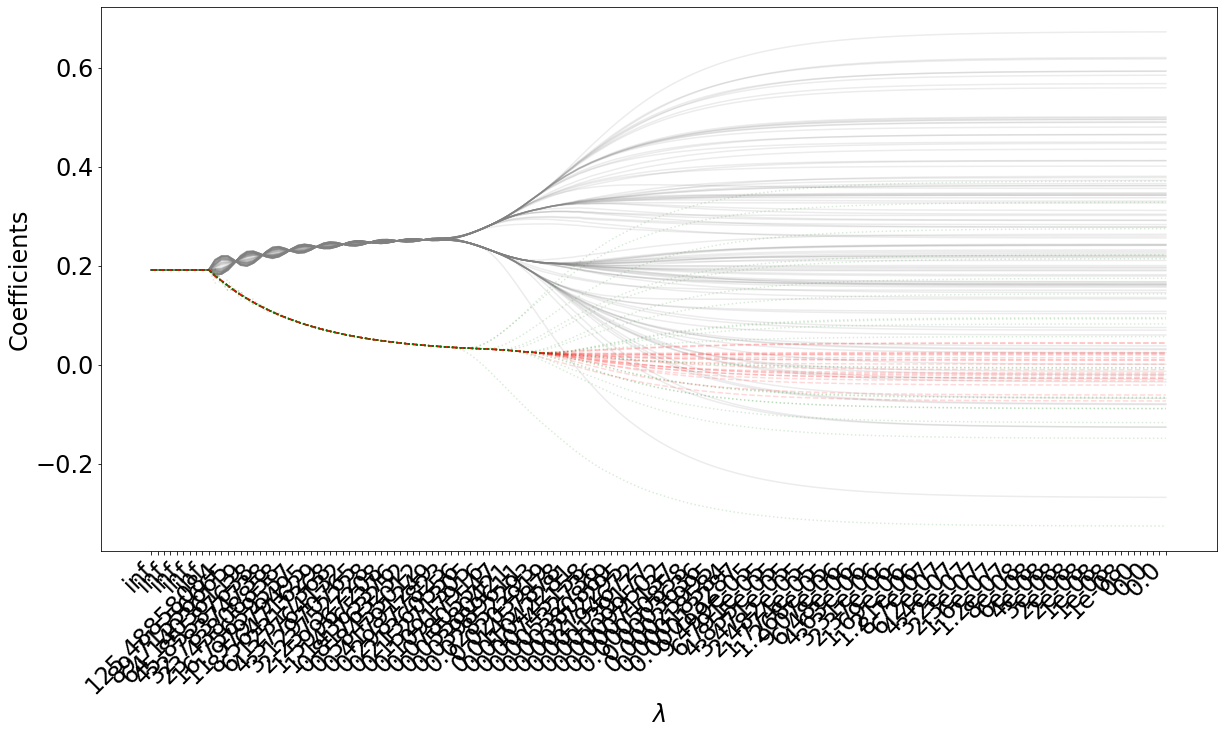

In [58]:
path_plot(np.asarray(A_list)[:,:,6:7], penalty_list, plot_range=[0,len(penalty_list)],cut_vars=False, true_clusters=true_clusters)



threshold: [[[1.32928084]]]


/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:507: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/logang/anaconda3/envs/pytorch_pcmf/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:507: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/logang/anaconda3/envs/pytorch_pcmf/lib/pyth

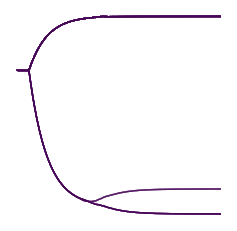

In [59]:
import seaborn as sns

def plot_dendrogram(Xhat,problem_rank,true_clusters_all,n_infinities,penalty_list):
    from pcmf import centroid_matrix
    Xhat_centroids = []
    for p in range(len(penalty_list)):
        Xhat_centroids.append(centroid_matrix(np.array(Xhat[p]),true_clusters_all))
    path_plot(np.asarray(Xhat_centroids)[:,:,6:7], penalty_list, plot_range=[n_infinities,-1],figsize=(4,4))
    plt.ylabel("$\hat{X}$ Rank "+str(problem_rank+1))
    plt.locator_params(axis='x',nbins=25)
    ax = plt.gca()
    ax.patch.set_facecolor('white')
    #plt.grid(b=None)
    #fig = plt.gcf()
    #fig.set_figheight(3)
    plt.axis('off')

cluster_pcmf = diff_graph_cluster(np.array(A_list[130]), D, comb_list, num_clusters).astype(int)
plot_dendrogram(np.asarray(A_list),num_components,cluster_pcmf,0,penalty_list)
    

array([12.90566677,  4.49771603,  2.13342688,  1.87236713])

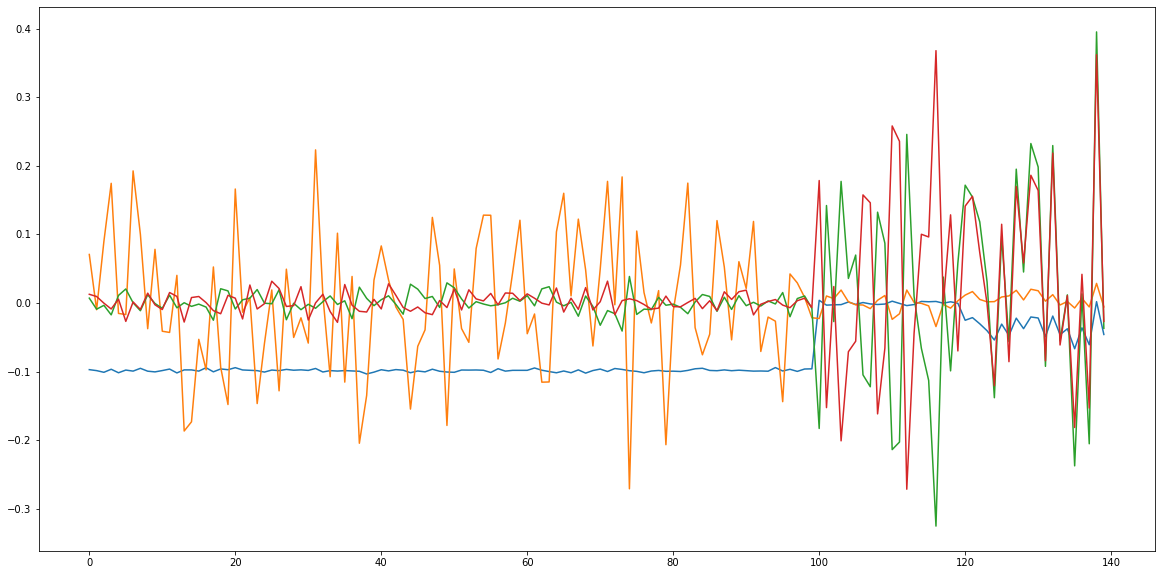

In [60]:
plt.figure(figsize=(20,10))
plt.plot(np.array(U_list[130]))
np.array(s_list[130])

